In [15]:
import random, numpy as np, pandas as pd
from matplotlib import pyplot as plt

In [16]:
alphap = 2
probp = 0.75
expon = 2 * alphap - 1
total_iterationp = 1_000_000
min_iterationp = 100_000
iteration_stepp = 50_000
ensemble_sizep = 50_000
progress_step = ensemble_sizep//100
filename = "Mdf_alpha_{}_p_{}".format(alphap,probp)

In [17]:
import scipy.special as sc

n_star = np.linspace(0,1,1_000_001)

def func_trans(n_star,alpha,p):
    """left-hand side of transcendental equation defined as a numpy array"""
    return (sc.gamma(n_star+alpha)*sc.gamma(2*alpha))/(sc.gamma(n_star+2*alpha)*sc.gamma(alpha))-1/(1+p)

In [18]:
def find_df(alpha,p):
    """root finding by minimizing the cost function: square of left-hanad side"""
    cost_array = func_trans(n_star,alpha,p)**2
    min_index = np.argmin(cost_array)
    df_value = n_star[min_index]
    #df_rounded = float("{:.6f}".format(df_value))
    #return df_rounded
    return df_value

In [19]:
def betadist(alpha):
    """gives a random number from beta distribution"""
    return random.betavariate(alpha,alpha)

In [20]:
def decision(probability):
    """
    decides with a given probability whether to keep the right part
    """
    if float(probability) > random.random():
        return float(1)
    else: 
        return float(0)

In [21]:
def splitting(segment):
    """
    splits a given segment. left and right are endpoints of the segment
    returns : 
        xL -> length of the left segment
        xR -> length of the right segment
        flag -> keeping the right segment
        xLp, xRp -> probability(unnormalized) for being selected
        change -> change of normalization const
    """
    xL = segment * betadist(alphap)
    flag = decision(probp)
    xR = (segment - xL) * flag
    xLp = xL**expon
    xRp = xR**expon
    change = xLp + xRp - segment**expon
    
    return xL, xR, xLp, xRp, change

In [22]:
def pickindex(frac_prob, frac_sum):
    """
    picks up a segment to be subsequently split
    """
    r = random.uniform(0,1)
    
    if r <= frac_sum:
        sum_ = 0
        for index in range(len(frac_prob)):
            sum_ += frac_prob[index]
            if sum_ < r:
                continue
            else:
                return index

In [23]:
fractal_dim = find_df(alphap,probp)

def fractal_length(lengths):

    M_frac = 0

    for i in lengths:
        if i != float(0):
            M_frac += i**fractal_dim
            pass
        pass
    return M_frac

In [24]:
def realization_value(total_iteration, min_iteration, iteration_step):
    
    lengths = [1.]
    frac_prob = [1.] # raw probability, not normalized
    frac_sum = 1.0

    iteration_list = list(range(min_iteration, total_iteration + 1, iteration_step))
    
    M_realization = []
    
    for i in range(total_iteration + 1):
        
        index = pickindex(frac_prob, frac_sum)
        
        if index != None:

            xL, xR, xLp, xRp, change = splitting(lengths[index])
            
            lengths[index] = xL
            frac_prob[index] = xLp 
            
            if xR != float(0):
                lengths.append(xR)
                frac_prob.append(xRp)
            
            frac_sum += change
            pass
        
        if i+1 in iteration_list:
            M_frac = fractal_length(lengths)
            M_realization.append(M_frac)
        pass 
      
    return np.array(M_realization)

In [25]:
def ensemble_average(total_iteration, min_iteration, iteration_step, ensemble_size):

    data_points = int ((total_iteration - min_iteration)/iteration_step + 1)
    M_ensemble = np.zeros(data_points)
    
    for i in range(ensemble_size):
        if i % progress_step == 0:
            print("working with realization ",i)
        M_list = realization_value(total_iteration, min_iteration, iteration_step)
        M_ensemble += M_list
        pass
    
    Mdf_list = M_ensemble/ensemble_size
    
    return Mdf_list

In [26]:
time_list = np.arange(min_iterationp, total_iterationp+iteration_stepp, iteration_stepp)
Mdf_list = ensemble_average(total_iterationp, min_iterationp, iteration_stepp, ensemble_sizep)
Mdf_avg = np.average(Mdf_list)

working with realization  0
working with realization  500
working with realization  1000
working with realization  1500
working with realization  2000
working with realization  2500
working with realization  3000
working with realization  3500
working with realization  4000
working with realization  4500
working with realization  5000
working with realization  5500
working with realization  6000
working with realization  6500
working with realization  7000
working with realization  7500
working with realization  8000
working with realization  8500
working with realization  9000
working with realization  9500
working with realization  10000
working with realization  10500
working with realization  11000
working with realization  11500
working with realization  12000
working with realization  12500
working with realization  13000
working with realization  13500
working with realization  14000
working with realization  14500
working with realization  15000
working with realization  15500


In [27]:
import json

header = dict()
header['alpha'] = alphap
header['probability'] = probp
header['ensemble_size'] = ensemble_sizep
header['total_iteraion'] = total_iterationp
header['Mdf_avg']= "{:.5f}".format(Mdf_avg)
header['cols'] = ["t", "M_df"]

header_str = json.dumps(header)
print(header_str)
np.savetxt(filename, np.c_[time_list, Mdf_list], header=header_str)

{"alpha": 2, "probability": 0.75, "ensemble_size": 50000, "total_iteraion": 1000000, "Mdf_avg": "0.99863", "cols": ["t", "M_df"]}


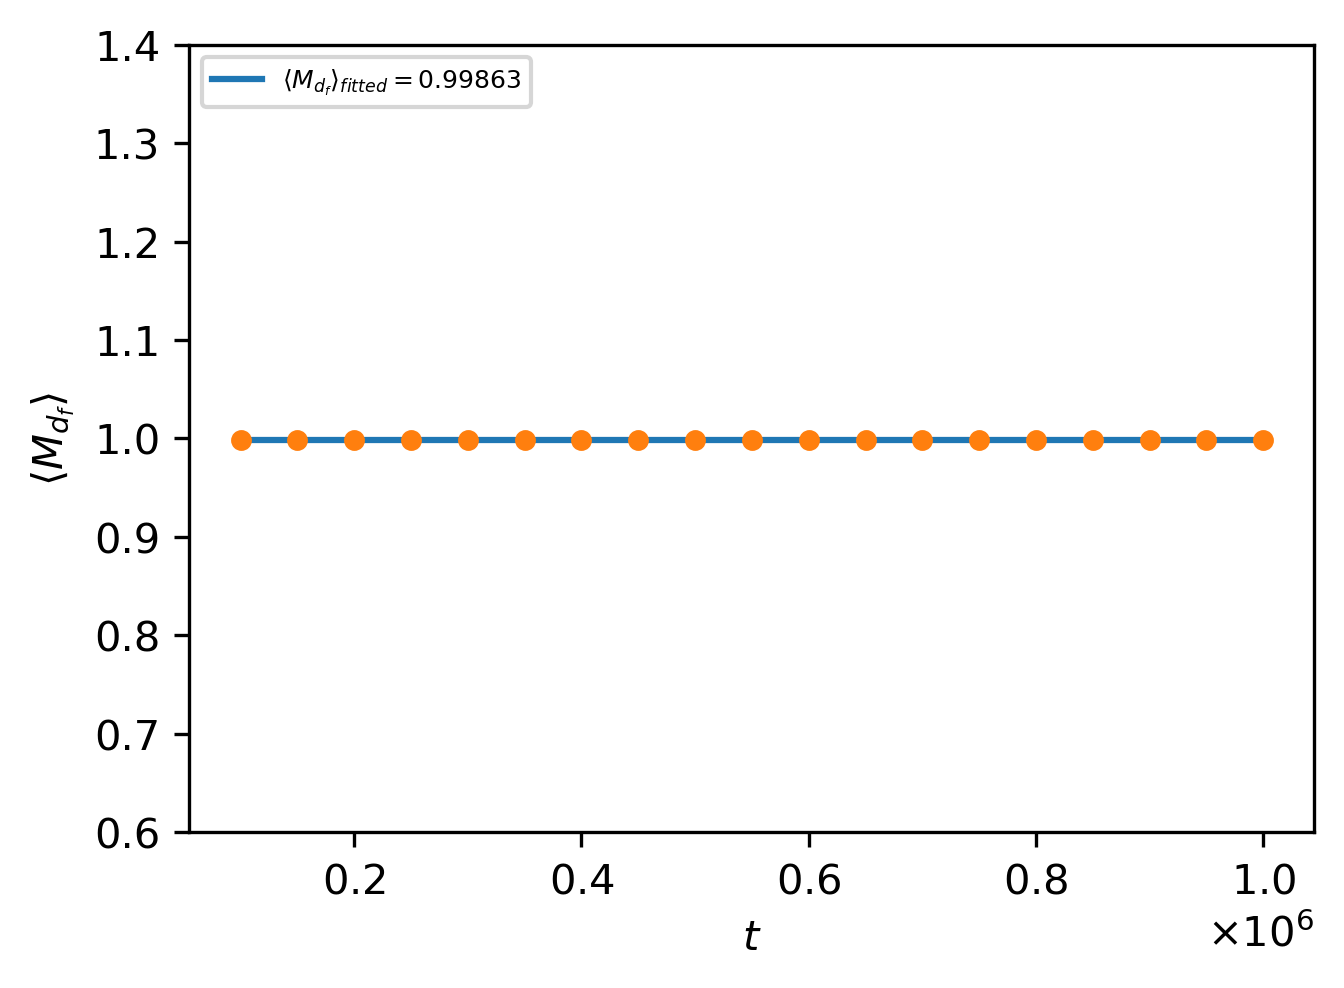

In [28]:
from matplotlib import ticker

fig, axes = plt.subplots(1,1,figsize = (5,3.5),dpi = 300)
plt.plot(time_list, 0*time_list+Mdf_avg, label=r"$\langle M_{d_f}\rangle_{fitted}=$"+"{:.5f}".format(Mdf_avg), color='tab:blue')
plt.plot(time_list, Mdf_list, "o", color='tab:orange', markersize=4)
plt.legend(fontsize=6, loc=2)
plt.xlabel(r"$t$")
plt.ylabel(r"$\langle M_{d_f}\rangle$")
plt.ylim([0.6, 1.4])
axes.set_position([0.15,0.15,0.75,0.75])

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
axes.xaxis.set_major_formatter(formatter) 

#plt.savefig("Mdf_alpha_2.pdf")